<a href="https://colab.research.google.com/github/mauro-nieva/Lint/blob/master/HPC/FiltroMedia_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#1 Introduccion

Este cuaderno aplica a una imagen determinada un filtro de suavizado  denominado filtro de la media. Su objetivo es utilizar Python[2] en la plataforma Colab [3] para resolver la problematica de manera paralela con la utilizacion de CUDA[4,5,6].

Las funciones de procesamiento de la imagen en el dominio espacial pueden expresarse como:[1] 

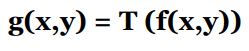

* f(x,y) es la imagen original.
* g(x,y) es la imagen procesada.
* T es un operador que actúa sobre f y se define en algún entorno de (x,y).

**Entorno de un punto (x,y)**

El entorno de un punto es una subimagen cuadrada o rectangular centrada en el punto (x,y).

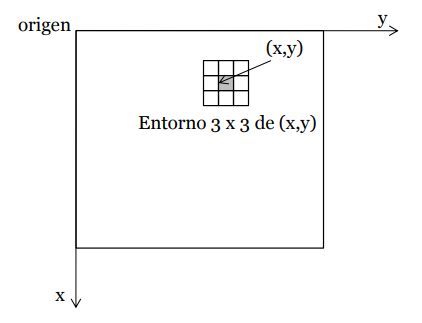

Pueden existir otros entornos, tales como aproximaciones de círculos, pero los cuadrados son los más comunes por ser los más fáciles de implementar.

**Técnica de filtrado lineal**

El filtro utilizado utiliza una técnica de filtrado lineal, este es un ejemplo usando un entorno 3x3.

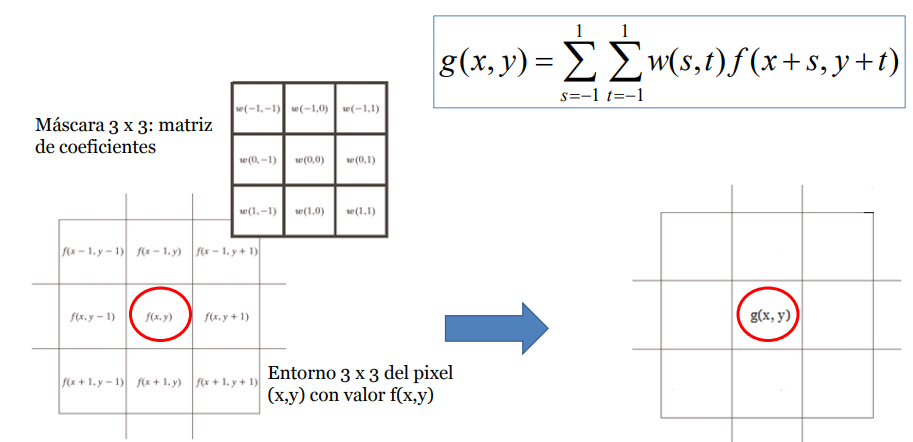

**Filtros de suavizado**

Un filtro de suavizado se utiliza en general para emborronar una imagen, permitiendo eliminar pequeños detalles antes de la segmentación de un objeto de interés o bien rellenar pequeños espacios. Además, otros de los usos muy comunes es eliminar el ruido.

**Filtro de la media**

El filtro de la media es un filtro lineal que sirve para:

* Suavizar imágenes, es decir, reducir la cantidad de variaciones de intensidad entre píxeles vecinos. 
* Conseguir que las intensidades de los objetos pequeños se mezclen con el fondo con el fin de detectar los objetos de mayor tamaño. 
* Eliminar ruido.

Su funcionamiento se basa en reemplazar el valor de cada píxel por la media de los valores de los píxeles vecinos. Se puede operar mediante convolución con una máscara determinada.

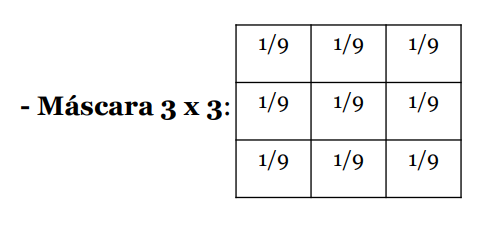

En los límites de la imagen podemos aplicar la máscara añadiendo un marco de ceros de la anchura adecuada. Esto puede tener efectos no deseados (p. ej., de difuminación en los límites de la imagen) pero, en general, poco significativos si la máscara es pequeña en relación con el tamaño de la imagen.

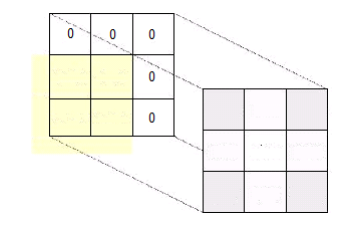

En este ejercicio se optó por duplicar el borde de la imagen, es decir el mismo pixel que la imagen original.
Este es un ejemplo con una máscara de 3x3 sin procesar el borde:

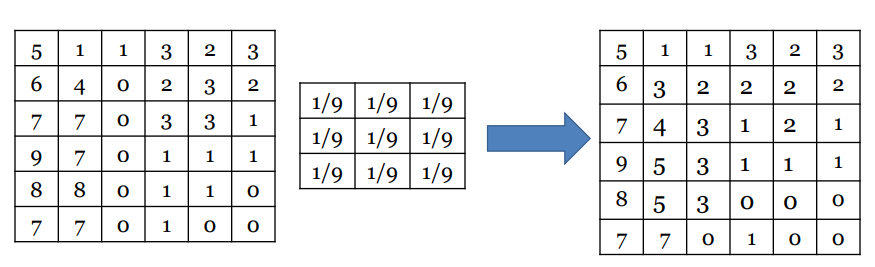








---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.
Se especifica el numero de mascara, este debe ser 3,5,7,9,15 o 35.

In [1]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://cms-assets.tutsplus.com/uploads/users/1181/posts/29202/image/cameramannoise.jpg" #@param {type:"string"}
mascara =  3#@param {type:"number"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg

--2020-12-03 00:04:59--  https://cms-assets.tutsplus.com/uploads/users/1181/posts/29202/image/cameramannoise.jpg
Resolving cms-assets.tutsplus.com (cms-assets.tutsplus.com)... 104.17.234.79, 104.17.233.79
Connecting to cms-assets.tutsplus.com (cms-assets.tutsplus.com)|104.17.234.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166658 (163K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 162.75K  --.-KB/s    in 0.01s   

2020-12-03 00:05:00 (10.7 MB/s) - ‘imagen.jpg’ saved [166658/166658]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 7.8MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621146 sha256=a9bda7d1b2dbcf7a890164a6e0f5c15af6fbfee7ba61d768a3c206f4dcd78ac2
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=0baa662a219148919ddca85aa8468ebdca6ac9b48f0ee26c0300d6a9a7f69733
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


---
# 3 Desarrollo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen del filtro: imagen.jpg- [850, 850]
Thread: [ 32 , 32  ], Bloque : [ 27 , 27 ]
Total de Thread: [ 864 , 864  ]  =  746496
Tiempo TOTAL:  149.41 [ms]
Tiempo GPU  :  0.243 [ms]


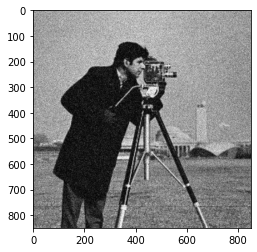

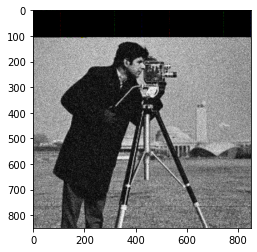

In [6]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
from skimage import io
import math
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Validacion de datos de entrada

try:
  if mascara!=3 and mascara!=5 and mascara!=7 and mascara!=9 and mascara!=15 and mascara!=35 :
    raise Exception("mascara incorrecta")
except Exception:
    sys.exit("La mascara debe ser 3,5,7,9,15 o 35.")

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image=io.imread(img_nombre)/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1

# Optengo las proporsiones de la imagen. 
img_alto= image.shape[1]; 
img_ancho = image.shape[0];

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

#obtengo los bordes de la imagen para no procesarlos
bordes=mascara/2
bordes_entero=math.modf(bordes)[1]

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
texture<unsigned char, cudaTextureType2D> tex8u;

__global__ void kernel_img( int ancho, int alto, int mascara, int bordes, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  float igual=0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    if (idy<bordes || idy>alto-(bordes+1) || idx<bordes || idx>ancho-(bordes+1))
    {
      igual = (float)img_O[(idx+(idy*ancho))*3    ];  
      igual +=(float)img_O[((idx+(idy*ancho))*3)+1];  
      igual +=(float)img_O[((idx+(idy*ancho))*3)+2];   
      
      img_R[(idx+(idy*ancho))*3  ] = (char) igual;
      img_R[(idx+(idy*ancho))*3+1] = (char) igual;
      img_R[(idx+(idy*ancho))*3+2] = (char) igual;
    }
    else
    {
      float suma=0;
      
      for(int k=0;k<mascara;k++)
      {
        for(int j=0;j<mascara;j++)
        {
          suma += tex2D(tex8u,idx - j,idy - k);
        }
      }

      // Escribo el color del pixel.
      img_R[(idx+(idy*ancho))*3  ] = (char) suma/(mascara*mascara);
      img_R[(idx+(idy*ancho))*3+1] = (char) suma/(mascara*mascara);
      img_R[(idx+(idy*ancho))*3+2] = (char) suma/(mascara*mascara);
    }
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 32
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 32
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), numpy.int32(mascara), numpy.int32(bordes_entero), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )


---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar y la mascara.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  try except        | Validacion de datos de entrada
CPU      |  imread          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  bordes        | Se obtienen los indices de borde de la imagen.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.


---
# 5 Conclusiones

Con respecto al modelo secuencial, este desarrollo aplicando GPU para la aplicacion del filtro de la media es mucho mas rapido con cualquier mascara seleccionada. Sin embargo, esta mejora se logra a traves de un codigo mucho mas complejo y con mas caracteristicas a tener en cuenta. La cantidad de hilos, la determinacion de los bloques, el manejo de memoria y la definicion del codigo del kernel son bastante sensibles.

---
# 6 Bibliografía

[1] Procesamiento en el dominio espacial: [Pagina asignatura](http://asignatura.us.es/imagendigital/Tema2-ParteII_Filtros.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] Documentación PyCUDA: [WEB](https://documen.tician.de/pycuda/index.html)

[5] Repositorio de PyCUDA: [WEB](https://pypi.python.org/pypi/pycuda)

[6] Cuda filtro promedio de imagen: [Pagina StackOverflow](https://stackoverrun.com/es/q/3875400)
